<a href="https://colab.research.google.com/github/Gerol-steiner/Knowledge/blob/main/theme2_sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# theme2 sample code

このサンプルコードは、テーマ2の課題を PyTorch + PyTorch Lightning を使って実装したコードです。  
精度向上の余地を残したコードになっており、精度向上につながる部分は、コード中に「精度向上のヒント」というコメントを入れているので参考にしてください。

このサンプルコードは、2025年6月16日時点の Google Colab (T4-GPUランタイム) 上で動作することを確認済みです。  
また、必要なライブラリを導入してディレクトリのパスを修正すれば、GPUを搭載したローカル環境上でも動作します。

利用する画像ファイルは事前に Google Drive に格納しておく必要があるため、ガイドに従って、Google Drive に `MDXQ` フォルダを作成し、配下に `train` と `test` データを格納してください。

**ディレクトリ構造**

- Google Drive （マイドライブ）
  - `MDXQ` フォルダ
    - `test` フォルダ
      - `000.jpeg`
      - `001.jpeg`～
    - `train` フォルダ
      - `bridge` フォルダ
      - `horn` フォルダ
      - `potato` フォルダ
      - `regular` フォルダ
    - `theme2_sample_code.ipynb` （このファイル）

## 🔖実行環境の設定

実行している環境に合わせた設定を行います。  
Google Colab 上で動かしている場合は、次の設定を行います。  

- Google Drive に接続（マウント）
- 実行に必要なPythonライブラリの導入

Google Colab 以外の個別環境で動かしている場合は、適宜必要な設定を行ってください。


In [ ]:
!pwd

/content


In [ ]:
import importlib
import sys

# Google Colab 上で実行しているかどうかを判断するフラグ
ON_COLAB = "google.colab" in sys.modules
print("ON_COLAB:", ON_COLAB)

if ON_COLAB:
    # Google Drive にマウントする
    drive = importlib.import_module("google.colab.drive")
    drive.mount("/content/drive")

    # 必要なライブラリをインストール
    !pip install lightning==2.5.1

ON_COLAB: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd


/content


In [ ]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Aug 10 07:37 .
drwxr-xr-x 1 root root 4096 Aug 10 07:34 ..
drwxr-xr-x 4 root root 4096 Aug  7 13:42 .config
drwx------ 6 root root 4096 Aug 10 07:37 drive
drwxr-xr-x 1 root root 4096 Aug  7 13:42 sample_data


## 🔖利用するライブラリのインポート

以降の処理で利用するPythonのライブラリを読み込みます。  

また、再実行時の再現性を高めるために、乱数シード値を固定しています。  
乱数シードを固定しておくと、ランダムにシャッフルする処理などが同じパターンで再現できます。

In [ ]:
import os
import glob
import random
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchmetrics import Accuracy, Precision, Recall, F1Score

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# 再現性を確保するために乱数シード値を設定
pl.seed_everything(42, workers=True)

# 利用している主要ライブラリのバージョンとCUDAの利用可否を表示
print(f"\nPyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

INFO:lightning_fabric.utilities.seed:Seed set to 42



PyTorch version: 2.6.0+cu124
PyTorch Lightning version: 2.5.2
CUDA available: False


## 🔖パラメータの定義

全体的に利用する設定パラメータを、管理しやすいように、まとめて定義しています。  

- `MAX_IMAGES_PER_CLASS` : <br/>学習と検証に利用する、各クラス単位の画像最大数を指定します。<br/>一般的に、学習に利用する画像数が多いほど精度は高くなりますが、学習時間は長くなるため、サンプルコードでは画像枚数を制限しています。<br/>この値を`MAX_IMAGES_PER_CLASS = None`とすれば、全ての画像が利用されるようになります。

- `MAX_EPOCHS` : <br/>学習時の最大エポック回数を指定します。<br/>最適なエポック数は、利用するデータやモデルによって変わってくるため、必要に応じて調整してください。<br/>
なお、このサンプルコードでは、学習を連続で数回繰り返しても精度が向上しない場合は、最大エポックに達していなくても、そこで学習をストップする「アーリーストッピング」の仕組みを組み込んでいます。

- `BATCH_SIZE` : <br/>画像を1枚ずつ学習するのではなく、このバッチサイズで指定した枚数の画像をまとめて学習するようにします。<br/>バッチサイズが大きければ学習時間を短縮できますが、必要なGPUのメモリも増えるため、利用環境に合わせて調整してください。<br/>一般的には「8, 16, 32, 64」などの値が利用されます。（128を超えるような大きな値は、あまり使われません）

- `TRAIN_VAL_SPLIT` : <br/>利用するデータのうち、何割を検証用に使うかを指定します。<br/>検証用のデータは学習には利用されないため、検証用に使う比率を増やせば、その分、学習で利用できる画像数が少なくなります。<br/>一般的には、`0.1～0.3`（1～3割）の値が多く使われます。

- `FREEZE_BACKBONE` : <br/>モデルの学習パターンを指定します。<br/>`True`にすれば、既に学習済みのモデルをそのまま利用する「転移学習」が使われるようになります。学習時間を短縮できる反面、精度が少し下がりやすくなります。<br/>`False`にすれば、追加で学習を行う「ファインチューニング」が行われるようになり、学習時間は延びますが、精度向上が期待できます。

教材で提供されているtrain/test画像を格納したディレクトリのパスは、`TRAIN_DIR`と`TEST_DIR`で指定します。  
ガイドと異なる場所に格納する場合は、利用環境に合わせて適宜パスを書き換えてください。

In [ ]:
# 各クラスごとに利用する画像数の上限を設定（Noneで全ての画像を使用）
# *** 精度向上のヒント: 学習に使うデータを増やしてみてください ***
MAX_IMAGES_PER_CLASS = 15

# クラスラベルの設定
CLASS_NAMES = ["bridge", "horn", "potato", "regular"]
NUM_CLASSES = len(CLASS_NAMES)

# 学習パラメータ
MAX_EPOCHS = 100  # 最大エポック数
BATCH_SIZE = 16  # バッチサイズ（GPUメモリに応じて調整）
TRAIN_VAL_SPLIT = 0.2  # 検証用データの割合（0.2なら20%を検証用に使用）

# モデルの設定パラメータ
IMG_SIZE = 224  # モデルに入力する画像のサイズ（224x224）
# 【変更 1/3】 ★★★★★★ 転移学習ではなくファインチューニングにより事前学習済みモデルのバックボーンのパラメータも学習対象に含める ★★★★★★
FREEZE_BACKBONE = False  # Trueで転移学習、Falseでファインチューニング
# ★★★★★ 以上、追記修了 ★★★★★

# 画像ファイルとして扱うファイル拡張子
IMAGE_EXTENSIONS = ["*.jpg", "*.jpeg", "*.png"]

# 画像ファイルを格納するディレクトリ（それぞれの環境に合わせて適宜変更してください）
# *** 精度向上のヒント: オリジナルの大きな画像ではなく、基板部分だけを切り出した加工済みの画像などで試してみてください ***
TRAIN_DIR = "/content/drive/MyDrive/MDXQ/train"
TEST_DIR = "/content/drive/MyDrive/MDXQ/test"

# 学習済みのモデルデータや提出用のCSVファイルを格納するディレクトリ
LOG_DIR = "/content/drive/MyDrive/MDXQ/logs"  # 学習のログやモデルの格納先
CSV_DIR = "/content/drive/MyDrive/MDXQ/csv"

# 画像のディレクトリが存在するかチェック
assert os.path.exists(TRAIN_DIR), f"TRAIN_DIRが存在しません: {TRAIN_DIR}"
assert os.path.exists(TEST_DIR), f"TEST_DIRが存在しません: {TEST_DIR}"

## 🔖データを学習用と検証用に分割


### 利用するデータの準備

実際の「学習と検証」に利用する画像データと、その正解ラベル（regular/bridge/horn/potato）を取得します。


In [ ]:
def get_image_paths_and_labels(data_dir, max_per_class=None, shuffle=True):
    """
    指定されたディレクトリから画像パスとラベルを取得

    Args:
        data_dir: データディレクトリのパス
        max_per_class: 各クラスから取得する最大画像数（Noneで全て取得）
        shuffle: 画像をランダムにシャッフルするかどうか

    Returns:
        image_paths: 画像パスのリスト
        labels: ラベルのリスト
    """
    image_paths = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"警告: {class_dir} が見つかりません")
            continue

        # 画像ファイルを取得
        class_images = []
        for ext in IMAGE_EXTENSIONS:
            class_images.extend(glob.glob(os.path.join(class_dir, ext)))

        # ランダムにシャッフル
        if shuffle:
            random.shuffle(class_images)

        # 画像数の制限がある場合は、指定された数だけ取得
        if max_per_class is not None:
            class_images = class_images[:max_per_class]

        print(f"{class_name:8}: {len(class_images):-4} 枚の画像を使用")

        image_paths.extend(class_images)
        labels.extend([class_idx] * len(class_images))

    return image_paths, labels


# 訓練データの画像パスとラベルを取得
train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR, MAX_IMAGES_PER_CLASS)
print("-" * 40)
print(f"利用する画像の総数: {len(train_paths)} 枚")

bridge  :   15 枚の画像を使用
horn    :   15 枚の画像を使用
potato  :   15 枚の画像を使用
regular :   15 枚の画像を使用
----------------------------------------
利用する画像の総数: 60 枚


In [ ]:
!ls "/content/drive/MyDrive/MDXQ/train"

bridge	horn  potato  regular


In [ ]:
!ls "/content/drive/MyDrive/MDXQ/train/bridge"
!ls "/content/drive/MyDrive/MDXQ/train/horn"
!ls "/content/drive/MyDrive/MDXQ/train/potato"
!ls "/content/drive/MyDrive/MDXQ/train/regular"

bridge_000.jpeg  bridge_008.jpeg  bridge_016.jpeg  bridge_024.jpeg
bridge_001.jpeg  bridge_009.jpeg  bridge_017.jpeg  bridge_025.jpeg
bridge_002.jpeg  bridge_010.jpeg  bridge_018.jpeg  bridge_026.jpeg
bridge_003.jpeg  bridge_011.jpeg  bridge_019.jpeg  bridge_027.jpeg
bridge_004.jpeg  bridge_012.jpeg  bridge_020.jpeg  bridge_028.jpeg
bridge_005.jpeg  bridge_013.jpeg  bridge_021.jpeg  bridge_029.jpeg
bridge_006.jpeg  bridge_014.jpeg  bridge_022.jpeg
bridge_007.jpeg  bridge_015.jpeg  bridge_023.jpeg
horn_000.jpeg  horn_012.jpeg  horn_024.jpeg  horn_036.jpeg  horn_048.jpeg
horn_001.jpeg  horn_013.jpeg  horn_025.jpeg  horn_037.jpeg  horn_049.jpeg
horn_002.jpeg  horn_014.jpeg  horn_026.jpeg  horn_038.jpeg  horn_050.jpeg
horn_003.jpeg  horn_015.jpeg  horn_027.jpeg  horn_039.jpeg  horn_051.jpeg
horn_004.jpeg  horn_016.jpeg  horn_028.jpeg  horn_040.jpeg  horn_052.jpeg
horn_005.jpeg  horn_017.jpeg  horn_029.jpeg  horn_041.jpeg  horn_053.jpeg
horn_006.jpeg  horn_018.jpeg  horn_030.jpeg  horn_042.

### 学習用と検証用にデータを分割

利用データを、パラメータの定義部分で指定した`TRAIN_VAL_SPLIT`の比率で「学習用」と「検証用」に分割します。  
単純に分割すると、例えば「検証用画像にはregularばかりしか含まれていない」と言うような、クラスラベルの偏りが発生する場合があるため、ここではクラス分布を維持した形でデータを分割するようにしています。


In [ ]:
# 訓練・検証データを分割（クラス分布を保持）
train_paths_split, val_paths_split, train_labels_split, val_labels_split = train_test_split(
    train_paths, train_labels, test_size=TRAIN_VAL_SPLIT, stratify=train_labels, random_state=42
)

print(f"データ分割完了:")
print(f"  - 訓練データ: {len(train_paths_split):-4}枚")
print(f"  - 検証データ: {len(val_paths_split):-4}枚")

# 分割後のクラス分布を確認
train_dist = [train_labels_split.count(i) for i in range(NUM_CLASSES)]
val_dist = [val_labels_split.count(i) for i in range(NUM_CLASSES)]

print(f"\n訓練データのクラス分布: {dict(zip(CLASS_NAMES, train_dist))}")
print(f"検証データのクラス分布: {dict(zip(CLASS_NAMES, val_dist))}")

データ分割完了:
  - 訓練データ:   48枚
  - 検証データ:   12枚

訓練データのクラス分布: {'bridge': 12, 'horn': 12, 'potato': 12, 'regular': 12}
検証データのクラス分布: {'bridge': 3, 'horn': 3, 'potato': 3, 'regular': 3}


## 🔖学習と検証用のデータ定義

PyTorchでは、学習や検証に使うデータを、以下の3つの役割に分けて管理しています。  
慣れるまでは複雑に感じるかもしれませんが、どんなデータでも同じ仕組みで統一的に扱えるようになるため便利です。

- `transform` : データ加工などの前処理を行うもの（Datasetが使う）
- `Dataset` : 利用するデータを入れておく入れ物のようなもの（DataLoaderが使う）
- `DataLoader` : Datasetからデータを取り出すときに使うもの

これら3つは密接な関係があり、`DataLoader`→`Dataset`→`transform`というつながりになります。  
PyTorchは、`DataLoader`経由でデータにアクセスする形になります。

### transformの定義（データの変換処理）

学習や検証で利用する画像に対する変換処理を定義します。<br/>
学習用には`train_transform`で定義した処理、検証と実際のtest画像の推論には`val_test_transform`を使うようにしています。

学習用の`train_transform`に画像の反転や拡大縮小など、様々なデータオーグメンテーション処理を追加することで学習データのバリエーションを増やして、より汎化性能を高めることが可能になります。


In [ ]:
# ImageNetの統計値（事前学習済みモデル用）
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 訓練用変換（データオーグメンテーション付き）
train_transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        # 以下を追加
        # transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3)) # ランダムな領域を消去
    ]
)

# 検証・テスト用変換（オーグメンテーションなし）
val_test_transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

### Datasetの定義

PyTorchで利用するデータを格納しておくための、データセットクラスを作成します。  
各Dataset単位に、上記で定義したtransform（データ変換処理）も指定します。

In [ ]:
class CustomImageDataset(Dataset):
    """
    カスタム画像データセットクラス
    """

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 画像を読み込み
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        # 変換を適用
        if self.transform:
            image = self.transform(image)

        return image, label


# 学習と検証用にデータセットを作成
train_dataset = CustomImageDataset(train_paths_split, train_labels_split, train_transform)
val_dataset = CustomImageDataset(val_paths_split, val_labels_split, val_test_transform)

### DataLoaderの定義

実際の学習や推論を行う場合、PyTorchでは「データローダー」経由で必要なデータを読み込む形になります。  
このデータローダー経由で、指定したDatasetからバッチサイズなども考慮しながらデータを取り出せるようになります。

In [ ]:
# データローダーの並列処理のためのワーカー数を設定（Google Colabの場合は0推奨）
NUM_WORKERS = 0 if ON_COLAB else 4  # Google Colabでは0、それ以外は4を指定
print(f"データローダーのワーカー数: {NUM_WORKERS}")

# データローダーを作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

データローダーのワーカー数: 0


## 🔖PyTorch Lightning用モデルの定義



In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
from torchmetrics import Accuracy, Precision, Recall, F1Score

class theme2Classifier(pl.LightningModule):
    """
    PyTorch Lightning 画像分類モデル
    """
    def __init__(self, num_classes=4, freeze_backbone=True):
        super().__init__()
        self.save_hyperparameters()

        # ResNet50を使用するように修正（これが正しいモデル構造）
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # オリジナルの最終層を削除
        resnet50_in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # 新しいヘッドを定義
        # Dropout層と最終層を組み合わせたヘッド
        self.head = nn.Sequential(
            nn.Dropout(0.5), # 50%の確率でニューロンを無効化
            nn.Linear(resnet50_in_features, num_classes)
        )

        # バックボーンを固定するかどうか
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("バックボーンを固定しました（転移学習モード）")
        else:
            print("バックボーンも学習します（ファインチューニングモード）")

        # 損失関数（正解との誤差を調べるための関数）
        self.criterion = nn.CrossEntropyLoss()

        # 学習用メトリクス
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_precision = Precision(task="multiclass", num_classes=num_classes, average="weighted")
        self.train_recall = Recall(task="multiclass", num_classes=num_classes, average="weighted")
        self.train_f1 = F1Score(task="multiclass", num_classes=num_classes, average="weighted")

        # 検証用メトリクス
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_precision = Precision(task="multiclass", num_classes=num_classes, average="weighted")
        self.val_recall = Recall(task="multiclass", num_classes=num_classes, average="weighted")
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes, average="weighted")

        # グラフ描画用のメトリクスを保存しておく辞書
        self.train_metrics = {}  # 訓練用メトリクスの履歴(key=epoch)
        self.val_metrics = {}  # 検証用メトリクスの履歴(key=epoch)

    def forward(self, x):
        # バックボーンを通した後、テーマ2用の最終層を通して分類結果を得る
        features = self.backbone(x)
        return self.head(features)

    def training_step(self, batch, batch_idx):
        """訓練ステップ"""
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)

        # 予測値を取得
        preds = torch.argmax(logits, dim=1)

        # 訓練用メトリクスを更新
        self.train_accuracy(preds, labels)
        self.train_precision(preds, labels)
        self.train_recall(preds, labels)
        self.train_f1(preds, labels)

        # ログに記録
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """検証ステップ"""
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)

        # 予測値を取得
        preds = torch.argmax(logits, dim=1)

        # 検証用メトリクスを更新
        self.val_accuracy(preds, labels)
        self.val_precision(preds, labels)
        self.val_recall(preds, labels)
        self.val_f1(preds, labels)

        # ログに記録
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        """訓練エポック終了時の処理"""
        # 訓練用メトリクスを計算
        train_acc = self.train_accuracy.compute()
        train_precision = self.train_precision.compute()
        train_recall = self.train_recall.compute()
        train_f1 = self.train_f1.compute()

        # ログに記録
        self.log("train_acc_epoch", train_acc)
        self.log("train_precision_epoch", train_precision)
        self.log("train_recall_epoch", train_recall)
        self.log("train_f1_epoch", train_f1)

        # グラフ描画用にメトリクスの履歴を保存
        self.train_metrics[self.current_epoch + 1] = {
            "accuracy": train_acc.item(),
            "precision": train_precision.item(),
            "recall": train_recall.item(),
            "f1": train_f1.item(),
            "loss": self.trainer.logged_metrics.get("train_loss", 0.0).item(),
        }

        # メトリクスをリセット
        self.train_accuracy.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()

    def on_validation_epoch_end(self):
        """検証エポック終了時の処理"""
        # 検証用メトリクスを計算
        val_acc = self.val_accuracy.compute()
        val_precision = self.val_precision.compute()
        val_recall = self.val_recall.compute()
        val_f1 = self.val_f1.compute()

        # ログに記録
        self.log("val_acc_epoch", val_acc)
        self.log("val_precision_epoch", val_precision)
        self.log("val_recall_epoch", val_recall)
        self.log("val_f1_epoch", val_f1)

        # 訓練用メトリクスを取得（ログから）
        train_acc = self.trainer.logged_metrics.get("train_acc_epoch", 0.0)
        train_precision = self.trainer.logged_metrics.get("train_precision_epoch", 0.0)
        train_recall = self.trainer.logged_metrics.get("train_recall_epoch", 0.0)
        train_f1 = self.trainer.logged_metrics.get("train_f1_epoch", 0.0)

        # 1行でメトリクスを出力
        print(
            f"Epoch {(self.current_epoch+1):3d} | "
            f"Train - acc: {train_acc:.4f}, precision: {train_precision:.4f}, recall: {train_recall:.4f}, f1: {train_f1:.4f} | "
            f"Val - acc: {val_acc:.4f}, precision: {val_precision:.4f}, recall: {val_recall:.4f}, f1: {val_f1:.4f},"
        )

        # グラフ描画用にメトリクスの履歴を保存
        self.val_metrics[self.current_epoch + 1] = {
            "accuracy": val_acc.item(),
            "precision": val_precision.item(),
            "recall": val_recall.item(),
            "f1": val_f1.item(),
            "loss": self.trainer.logged_metrics.get("val_loss", 0.0).item(),
        }

        # メトリクスをリセット
        self.val_accuracy.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()

    def configure_optimizers(self):
        # バックボーンとヘッドのパラメータを分離
        backbone_params = self.backbone.parameters()
        head_params = self.head.parameters()

        # パラメータごとに異なる学習率を設定
        optimizer = optim.AdamW(
            [
                {'params': backbone_params, 'lr': 1e-5}, # バックボーンは小さい学習率
                {'params': head_params, 'lr': 1e-3}      # ヘッドは大きい学習率
            ],
            weight_decay=1e-2
        )

        scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=3, verbose=True
            ),
            'monitor': 'val_f1_epoch'
        }

        return [optimizer], [scheduler]

    # メトリクスの履歴を取得する
    def get_metrics_history(self):
        return self.train_metrics, self.val_metrics

    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, **kwargs):
        # チェックポイントをロード
        checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

        # ステートディクショナリを取得
        state_dict = checkpoint["state_dict"]

        # キーのマッピングを調整
        # nn.Sequential内でLinear層がhead.1として保存されている場合に対応
        new_state_dict = {}
        for k, v in state_dict.items():
            if "head.1." in k:
                new_key = k.replace("head.1.", "head.")
                new_state_dict[new_key] = v
            else:
                new_state_dict[k] = v

        # モデルをインスタンス化
        # __init__の引数を渡す必要がある場合はkwargsを使用
        model = cls(**kwargs)

        # ステートディクショナリをロード
        model.load_state_dict(new_state_dict, strict=False) # strict=Falseでキーの不一致を許容

        return model

## 🔖学習計画の準備

PyTorch Lightning を使って学習の準備を行います。  
学習全体を管理している「トレーナー」に対して、どのように学習させるかを設定します。


In [ ]:
!pip install tensorboard

# アーリーストッピングの設定
# F1スコアが指定されたエポック数以内に改善されない場合、学習を停止
# *** 精度向上のヒント: 必要に応じて中止するまでの最大エポック数(patience)を増やしてみてください ***
early_stopping = EarlyStopping(
    monitor="val_f1_epoch",
    mode="max",
    patience=6,
    verbose=True,
)

# F1スコアが最も高いモデルを保存するチェックポイントの設定
checkpoint = ModelCheckpoint(
    filename="best-model-{epoch:02d}-{val_f1_epoch:.3f}",
    monitor="val_f1_epoch",
    mode="max",
    save_top_k=1,  # 最も良いモデル1つを保存
)

# 結果を記録するTensorBoardロガーの設定
# *** ヒント: WandbLoggerに変更することで、W&Bでの可視化も可能です ***
logger = TensorBoardLogger(LOG_DIR)

# トレーナー設定
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stopping, checkpoint],
    logger=logger,
    accelerator="auto",  # GPUが利用可能な場合は自動で使用
    devices="auto",
    precision="16-true",  # 16ビット精度で学習（GPUメモリの節約）
    log_every_n_steps=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## 🔖学習

上記で定義したトレーナーが、自動で学習を進めていきます。  
学習に利用するデータ量やモデルの種類、環境などによって、学習時間は大きく異なります。

学習には数分～数時間程度の時間がかかります。

In [ ]:
# 学習させるモデルのインスタンスを作成
model = theme2Classifier(num_classes=NUM_CLASSES, freeze_backbone=FREEZE_BACKBONE)

# 学習実行
print(f"学習開始 - 最大エポック数: {MAX_EPOCHS}")
trainer.fit(model, train_loader, val_loader)

バックボーンも学習します（ファインチューニングモード）
学習開始 - 最大エポック数: 100


INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | backbone        | ResNet              | 23.5 M | train
1  | head            | Sequential          | 8.2 K  | train
2  | criterion       | CrossEntropyLoss    | 0      | train
3  | train_accuracy  | MulticlassAccuracy  | 0      | train
4  | train_precision | MulticlassPrecision | 0      | train
5  | train_recall    | MulticlassRecall    | 0      | train
6  | train_f1        | MulticlassF1Score   | 0      | train
7  | val_accuracy    | MulticlassAccuracy  | 0      | train
8  | val_precision   | MulticlassPrecision | 0      | train
9  | val_recall      | MulticlassRecall    | 0      | train
10 | val_f1          | MulticlassF1Score   | 0      | train
-----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.065    Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch   1 | Train - acc: 0.0000, precision: 0.0000, recall: 0.0000, f1: 0.0000 | Val - acc: 0.1667, precision: 0.2812, recall: 0.1667, f1: 0.1705,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_epoch improved. New best score: 0.100


Epoch   1 | Train - acc: 0.0000, precision: 0.0000, recall: 0.0000, f1: 0.0000 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch   2 | Train - acc: 0.2083, precision: 0.2431, recall: 0.2083, f1: 0.1503 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch   3 | Train - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch   4 | Train - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch   5 | Train - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch   6 | Train - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_f1_epoch did not improve in the last 6 records. Best score: 0.100. Signaling Trainer to stop.


Epoch   7 | Train - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000 | Val - acc: 0.2500, precision: 0.0625, recall: 0.2500, f1: 0.1000,


### 学習結果のグラフ表示

学習時に記録していた各メトリクスの値をグラフに描画します。

参考: PyTorch Lightning にはログを記録する仕組みもある（`self.log()`で保存している部分）ので、PyTorch Lightningの`Trainer`に指定する`logger`の種類を変更すれば、TensorBoardや [W&B](https://wandb.ai/) などでログを確認することも可能です。

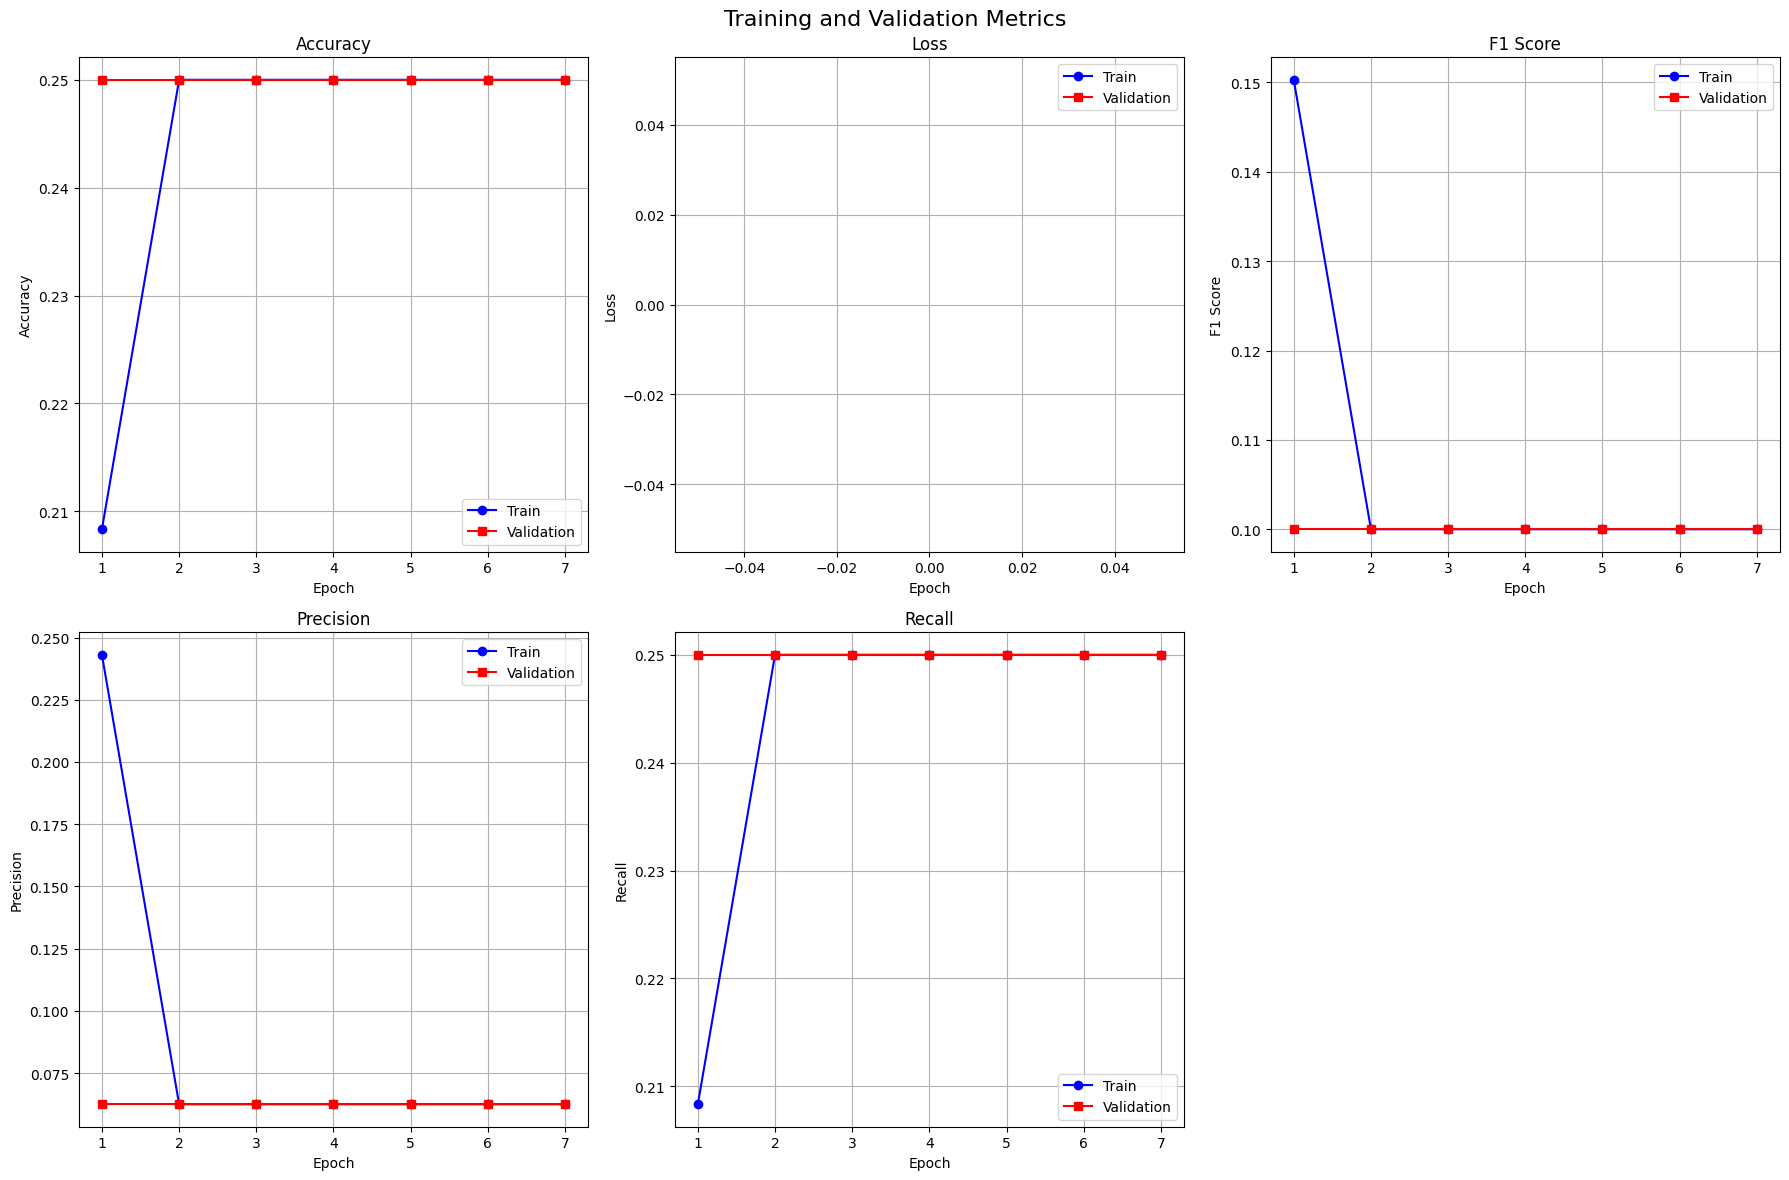

In [ ]:
import matplotlib.pyplot as plt

# 学習後のメトリクス履歴を取得
train_metrics, val_metrics = model.get_metrics_history()

# グラフ描画のための設定
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Training and Validation Metrics", fontsize=16)

# 各エポックのメトリクスを取得
epochs = list(train_metrics.keys())
train_acc = [train_metrics[epoch]["accuracy"] for epoch in epochs]
val_acc = [val_metrics[epoch]["accuracy"] for epoch in epochs]
train_loss = [train_metrics[epoch]["loss"] for epoch in epochs]
val_loss = [val_metrics[epoch]["loss"] for epoch in epochs]
train_precision = [train_metrics[epoch]["precision"] for epoch in epochs]
val_precision = [val_metrics[epoch]["precision"] for epoch in epochs]
train_recall = [train_metrics[epoch]["recall"] for epoch in epochs]
val_recall = [val_metrics[epoch]["recall"] for epoch in epochs]
train_f1 = [train_metrics[epoch]["f1"] for epoch in epochs]
val_f1 = [val_metrics[epoch]["f1"] for epoch in epochs]

# Plot Accuracy
axes[0, 0].plot(epochs, train_acc, "b-", label="Train", marker="o")
axes[0, 0].plot(epochs, val_acc, "r-", label="Validation", marker="s")
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Loss
axes[0, 1].plot(epochs, train_loss, "b-", label="Train", marker="o")
axes[0, 1].plot(epochs, val_loss, "r-", label="Validation", marker="s")
axes[0, 1].set_title("Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot F1 Score
axes[0, 2].plot(epochs, train_f1, "b-", label="Train", marker="o")
axes[0, 2].plot(epochs, val_f1, "r-", label="Validation", marker="s")
axes[0, 2].set_title("F1 Score")
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("F1 Score")
axes[0, 2].legend()
axes[0, 2].grid(True)

# Plot Precision
axes[1, 0].plot(epochs, train_precision, "b-", label="Train", marker="o")
axes[1, 0].plot(epochs, val_precision, "r-", label="Validation", marker="s")
axes[1, 0].set_title("Precision")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Recall
axes[1, 1].plot(epochs, train_recall, "b-", label="Train", marker="o")
axes[1, 1].plot(epochs, val_recall, "r-", label="Validation", marker="s")
axes[1, 1].set_title("Recall")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend()
axes[1, 1].grid(True)


# 空のサブプロットを非表示にする
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

## 🔖テスト用のデータ定義

`test`フォルダの画像を読み込むデータローダーを定義します。  
テスト用画像は正解ラベル（bridge/horn/potato/regular）が分かりませんが、データ形式を揃えるため、ダミー値で0を設定しています。（この値を使うことはないので値は何でも良い）

In [ ]:
# テストデータの画像パスを取得
test_image_paths = []
for ext in IMAGE_EXTENSIONS:
    test_image_paths.extend(glob.glob(os.path.join(TEST_DIR, ext)))

test_image_paths.sort()  # ファイル名でソート
print(f"テスト画像数: {len(test_image_paths)}")

# テストデータセットとローダーを作成
test_labels = [0] * len(test_image_paths)  # ラベルにはダミー値(0)を設定
test_dataset = CustomImageDataset(test_image_paths, test_labels, val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

テスト画像数: 213


## 🔖テスト画像の推論

学習済みのモデルを読み込んで、test画像の推論を行います。

サンプルコードでは、F1スコアが最も高かったモデルをファイル名から検索して読み込むようにしていますが、利用するモデルを指定したい場合は、`best_model_path`に利用したいモデルファイルのパスを直接指定してください。


In [ ]:
def get_best_model_path():
    # logger.root_dir配下のフォルダから、*.ckptファイルを列挙し、ファイル名のf1スコアが最も高いファイル名を返す
    # 注意: ファイル名に依存した処理になっているため、ファイル名が変わると正しく動作しなくなる可能性があります
    ckpt_files = glob.glob(os.path.join(logger.root_dir, "**", "*.ckpt"), recursive=True)
    if not ckpt_files:
        raise FileNotFoundError("チェックポイントファイルが見つかりません。")

    best_ckpt = max(ckpt_files, key=lambda x: float(x.split("val_f1_epoch=")[-1].split(".ckpt")[0]))
    return best_ckpt


# test画像の推論に使うモデルを指定（ファイル名からF1スコアが最も高いモデルを取得）
# 使うモデルを意図的にしたい場合は、best_model_pathにモデルのパスを直接指定してください
best_model_path = get_best_model_path()

# 利用するモデル
print(f"推論に使用するモデル: {best_model_path}")

推論に使用するモデル: /content/drive/MyDrive/MDXQ/logs/lightning_logs/version_4/checkpoints/best-model-epoch=21-val_f1_epoch=0.748.ckpt


In [ ]:
# 最良モデルをロード（チェックポイントから）
best_model = theme2Classifier.load_from_checkpoint(best_model_path)
print(f"読み込んだモデル: {best_model_path}")

# 推論モードに設定
best_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

# 推論実行
predictions = []
probabilities = []

with torch.no_grad():
    for batch in test_loader:
        images, _ = batch
        images = images.to(device)

        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

print(f"推論完了: {len(predictions)} 件")

# 予測結果の統計
pred_counts = {class_name: 0 for class_name in CLASS_NAMES}
for pred in predictions:
    pred_counts[CLASS_NAMES[pred]] += 1

print(f"\n予測結果の分布:")
for class_name, count in pred_counts.items():
    print(f"  {class_name:8}: {count:-4} 件")

バックボーンを固定しました（転移学習モード）
読み込んだモデル: /content/drive/MyDrive/MDXQ/logs/lightning_logs/version_4/checkpoints/best-model-epoch=21-val_f1_epoch=0.748.ckpt
推論完了: 213 件

予測結果の分布:
  bridge  :    4 件
  horn    :   47 件
  potato  :   58 件
  regular :  104 件


## 🔖指定形式でCSVファイル出力

最終的に提出するCSVファイルを作成します。

モデルは4クラス分類（bridge/horn/potato/regular）のため、推論結果には4種類の値が入っていますが、実際に提出するファイルは「正常:0、異常:1」にする必要があるため、値の変換も行っています。

In [ ]:
# 予測結果を格納するリスト
results = []
for _, (image_path, pred, prob) in enumerate(zip(test_image_paths, predictions, probabilities)):
    filename = os.path.basename(image_path)  # ファイル名
    predicted_class = CLASS_NAMES[pred]  # クラス名
    is_abnormal = 0 if predicted_class == "regular" else 1  # 正常・異常判定（regular=0(正常), その他=1(異常)）
    confidence = prob[pred]  # 予測確率
    results.append(
        {
            "filename": filename,
            "abnormal": is_abnormal,
            "predicted_class": predicted_class,
            "confidence": confidence,
        }
    )

# DataFrameに変換
df = pd.DataFrame(results)

# 要求されたフォーマットでCSV出力
os.makedirs(CSV_DIR, exist_ok=True)
output_file = os.path.join(CSV_DIR, "my_submission.csv")
output_df = df[["filename", "abnormal"]].copy()
output_df.to_csv(output_file, index=False, header=False)

# 実際に予測したクラスと確率を含む詳細な結果も保存（デバッグや分析用）
df.to_csv(os.path.join(CSV_DIR, "test_results.csv"), index=False)

# 結果の統計
print("\n判定結果:")
print("  - 正常 (regular):", (df["abnormal"] == 0).sum())
print("  - 異常 (potato/bridge/horn):", (df["abnormal"] == 1).sum())

# サンプル結果を表示
print("\nサンプル結果 (最初の10件):")
print(df.head(10)[["filename", "predicted_class", "abnormal", "confidence"]])

# 提出するファイルの保存場所を表示
print(f"\n次のファイルを提出してください: {output_file}")


判定結果:
  - 正常 (regular): 104
  - 異常 (potato/bridge/horn): 109

サンプル結果 (最初の10件):
   filename predicted_class  abnormal  confidence
0  000.jpeg          potato         1    0.309685
1  001.jpeg          potato         1    0.278101
2  002.jpeg         regular         0    0.327224
3  003.jpeg          potato         1    0.275841
4  004.jpeg         regular         0    0.311621
5  005.jpeg         regular         0    0.323526
6  006.jpeg         regular         0    0.334448
7  007.jpeg            horn         1    0.269032
8  008.jpeg         regular         0    0.278282
9  009.jpeg          potato         1    0.337342

次のファイルを提出してください: /content/drive/MyDrive/MDXQ/csv/my_submission.csv


In [ ]:
# 最良モデルをロード（チェックポイントから）
best_model = theme2Classifier.load_from_checkpoint(best_model_path)
print(f"読み込んだモデル: {best_model_path}")

# 推論モードに設定
best_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

# 推論実行
predictions = []
probabilities = []

with torch.no_grad():
    for batch in test_loader:
        images, _ = batch
        images = images.to(device)

        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

print(f"推論完了: {len(predictions)} 件")

# 予測結果の統計
pred_counts = {class_name: 0 for class_name in CLASS_NAMES}
for pred in predictions:
    pred_counts[CLASS_NAMES[pred]] += 1

print(f"\n予測結果の分布:")
for class_name, count in pred_counts.items():
    print(f"  {class_name:8}: {count:-4} 件")

バックボーンを固定しました（転移学習モード）
読み込んだモデル: /content/drive/MyDrive/MDXQ/logs/lightning_logs/version_4/checkpoints/best-model-epoch=21-val_f1_epoch=0.748.ckpt
推論完了: 213 件

予測結果の分布:
  bridge  :   50 件
  horn    :    2 件
  potato  :   30 件
  regular :  131 件


In [2]:
# Google Drive をマウント
from google.colab import drive
drive.mount('/content/drive')

# 必要なライブラリ
!pip install nbconvert pyppeteer

# --- 💡 ここから手動入力 ---
# 実行時にファイル名を入力するように促します
notebook_filename = input("変換したいノートブックのファイル名を正確に入力してください (例: MyNotebook.ipynb): ")
notebook_dir_gdrive = input("ノートブックが存在するGoogle Drive上のディレクトリパスを入力してください (例: MyDrive/Colab Notebooks): ")
# --- 💡 ここまで手動入力 ---

import os

# ノートブックのColab上のフルパスを構築
notebook_path_colab = os.path.join('/content/drive', notebook_dir_gdrive, notebook_filename)

# 保存先ディレクトリ名を定義
save_dir_name = "KnowledgeExport"

# 保存先ディレクトリのフルパスを構築
save_dir = os.path.join('/content/drive', notebook_dir_gdrive, save_dir_name)

# --- デバッグ情報 ---
print("--- デバッグ情報 ---")
print(f"入力されたファイル名: '{notebook_filename}'")
print(f"入力されたディレクトリ: '{notebook_dir_gdrive}'")
print(f"構築されたノートブックのフルパス: '{notebook_path_colab}'")
print(f"構築された保存先ディレクトリ: '{save_dir}'")
print("-------------------")
# --- デバッグ出力ここまで ---

# 保存先ディレクトリを作成（既に存在する場合は何もしません）
os.makedirs(save_dir, exist_ok=True)

# HTML出力 (テンプレートを'basic'に変更)
!jupyter nbconvert --to html --template basic --output-dir="{save_dir}" "{notebook_path_colab}" --output="{notebook_filename}.html"

# PDF出力
!jupyter nbconvert --to webpdf --allow-chromium-download --output-dir="{save_dir}" "{notebook_path_colab}" --output="{notebook_filename}.pdf"

print(f"✅ 完全HTMLと完全PDFを '{save_dir}' に保存しました")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
変換したいノートブックのファイル名を正確に入力してください (例: MyNotebook.ipynb): theme2_sample_code.ipynb
ノートブックが存在するGoogle Drive上のディレクトリパスを入力してください (例: MyDrive/Colab Notebooks): MyDrive/MDXQ
--- デバッグ情報 ---
入力されたファイル名: 'theme2_sample_code.ipynb'
入力されたディレクトリ: 'MyDrive/MDXQ'
構築されたノートブックのフルパス: '/content/drive/MyDrive/MDXQ/theme2_sample_code.ipynb'
構築された保存先ディレクトリ: '/content/drive/MyDrive/MDXQ/KnowledgeExport'
-------------------
[NbConvertApp] Converting notebook /content/drive/MyDrive/MDXQ/theme2_sample_code.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.p

In [ ]:
!pwd

/content
